In [1]:
import sys
sys.path.insert(0, "./../../scripts")

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def imshowbar(fig,ax,A,showbar=True,**kwargs):
    imsh = ax.imshow(A,**kwargs)
    if showbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(imsh, cax=cax, orientation="vertical")
        return cbar

In [3]:
plt.rcParams["font.sans-serif"] = ["PT Sans","DejaVu Sans"]

# Plot Exact and Partitioned Interocular Mean Weights From Supp Fig S6a,b

In [4]:
from scipy.interpolate import UnivariateSpline
from dmft import basesubwrapnorm
from scipy.interpolate import interp1d

gaus = np.linspace(0,90,91)
hwhm1 = np.zeros_like(gaus)
hwhm2 = np.zeros_like(gaus)

def calc_HWHM(data,n):
    itp = UnivariateSpline(np.arange(-n*3//4,n*3//4)/n*180,np.concatenate((data[-n*3//4:],data[:n*3//4])),s=0)
    half = itp(22.5) / 2
    roots = np.sort(UnivariateSpline(np.linspace(-60,60,121),itp(np.linspace(-60,60,121))-half,s=0).roots())
    if len(roots) > 2:
        return (0.5*np.abs(roots[-2]-roots[1]),0.5*np.abs(roots[-1]-roots[0]))
    else:
        return (0,0.5*np.abs(roots[-1]-roots[0]))

for idx,s in enumerate(gaus):
    if np.isclose(s,0):
        hwhm1[idx],hwhm2[idx] = 22.5,22.5
    else:
        data = basesubwrapnorm(np.arange(180)*180/180+22.5,s) + basesubwrapnorm(np.arange(180)*180/180-22.5,s)
        hwhm1[idx],hwhm2[idx] = calc_HWHM(data,180)

hwhm1_itp = interp1d(gaus,hwhm1)
hwhm2_itp = interp1d(gaus,hwhm2)

In [5]:
from dmft import struct_fact,inv_overlap

widths = np.linspace(5,50,10)
inv_ov = inv_overlap(np.array([0,-45]),widths[:,None])[:,:,0].sum(-1)

z0s = (struct_fact(0,np.sqrt(widths[:,None]**2+widths[None,:]**2),widths[:,None]) \
    + struct_fact(45,np.sqrt(widths[:,None]**2+widths[None,:]**2),widths[:,None])) * inv_ov[:,None]
z90s = 2*struct_fact(90,np.sqrt(widths[:,None]**2+widths[None,:]**2),widths[:,None]) * inv_ov[:,None]

In [6]:
from dmft import wrapnormdens
from scipy.integrate import dblquad

hwhm1s = hwhm1_itp(widths)
hwhm2s = hwhm2_itp(widths)

def part_fact0(z,skern,hwhm1,hwhm2,L=180):
    return (dblquad(lambda y,x: wrapnormdens(x-y+z,skern,L),hwhm1,hwhm2,hwhm1,hwhm2)[0] \
        + dblquad(lambda y,x: wrapnormdens(x-y+z,skern,L),hwhm1,hwhm2,-hwhm2,-hwhm1)[0]) * 2*np.pi / 180 / (hwhm2-hwhm1)
def part_fact90(z,skern,hwhm1,hwhm2,L=180):
    return (dblquad(lambda y,x: wrapnormdens(x-y+z,skern,L),hwhm1,hwhm2,-hwhm1,hwhm1)[0] \
        + dblquad(lambda y,x: wrapnormdens(x-y+z,skern,L),hwhm1,hwhm2,hwhm2,180-hwhm2)[0]) * 2*np.pi / 180 / (90-(hwhm2-hwhm1))
vpart_fact0 = np.vectorize(part_fact0)
vpart_fact90 = np.vectorize(part_fact90)

p0s = vpart_fact0(0,widths[None,:],hwhm1s[:,None],hwhm2s[:,None])
p90s = vpart_fact90(0,widths[None,:],hwhm1s[:,None],hwhm2s[:,None])

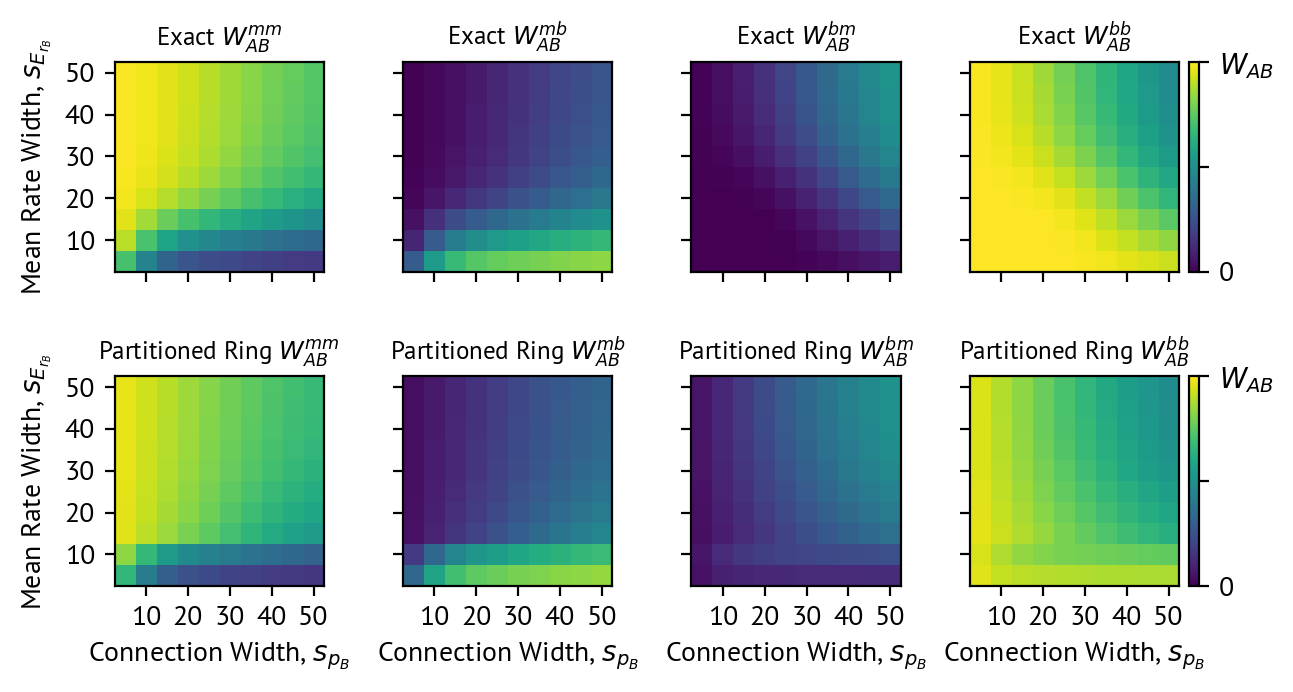

In [8]:
fig,axs = plt.subplots(2,4,figsize=(1.8*4,1.7*2),dpi=200,sharex=True,sharey=True)
fig.subplots_adjust(wspace=0.15,hspace=0.5)

imshowbar(fig,axs[0,0],z0s,showbar=False,origin="lower",vmin=0,vmax=1,extent=(2.5,52.5,2.5,52.5))
imshowbar(fig,axs[0,1],1-z0s,showbar=False,origin="lower",vmin=0,vmax=1,extent=(2.5,52.5,2.5,52.5))
imshowbar(fig,axs[0,2],z90s,showbar=False,origin="lower",vmin=0,vmax=1,extent=(2.5,52.5,2.5,52.5))
cbar = imshowbar(fig,axs[0,3],1-z90s,origin="lower",vmin=0,vmax=1,extent=(2.5,52.5,2.5,52.5))
cbar.ax.set_yticks([0,0.5,1],["0","",r"$W_{AB}$"])
imshowbar(fig,axs[1,0],p0s,showbar=False,origin="lower",vmin=0,vmax=1,extent=(2.5,52.5,2.5,52.5))
imshowbar(fig,axs[1,1],1-p0s,showbar=False,origin="lower",vmin=0,vmax=1,extent=(2.5,52.5,2.5,52.5))
imshowbar(fig,axs[1,2],p90s,showbar=False,origin="lower",vmin=0,vmax=1,extent=(2.5,52.5,2.5,52.5))
cbar = imshowbar(fig,axs[1,3],1-p90s,origin="lower",vmin=0,vmax=1,extent=(2.5,52.5,2.5,52.5))
cbar.ax.set_yticks([0,0.5,1],["0","",r"$W_{AB}$"])

axs[0,0].set_xticks([10,20,30,40,50])
axs[0,0].set_yticks([10,20,30,40,50])

for i in range(4):
    axs[1,i].set_xlabel(r"Connection Width, $s_{p_B}$")
axs[0,0].set_ylabel(r"Mean Rate Width, $s_{E_{r_B}}$")
axs[1,0].set_ylabel(r"Mean Rate Width, $s_{E_{r_B}}$")

axs[0,0].set_title(r"Exact $W_{AB}^{mm}$",fontsize=9)
axs[0,1].set_title(r"Exact $W_{AB}^{mb}$",fontsize=9)
axs[0,2].set_title(r"Exact $W_{AB}^{bm}$",fontsize=9)
axs[0,3].set_title(r"Exact $W_{AB}^{bb}$",fontsize=9)
axs[1,0].set_title(r"Partitioned Ring $W_{AB}^{mm}$",fontsize=9)
axs[1,1].set_title(r"Partitioned Ring $W_{AB}^{mb}$",fontsize=9)
axs[1,2].set_title(r"Partitioned Ring $W_{AB}^{bm}$",fontsize=9)
axs[1,3].set_title(r"Partitioned Ring $W_{AB}^{bb}$",fontsize=9)

# fig.tight_layout()
fig.savefig("./supp_fig_6ab.pdf")